# Scraping Yahoo! Finance Most Active Stocks

![](https://i.imgur.com/Jhx4oL9.png)

## Project statement

In this project I'll be web scraping Yahoo! Finance. I'll specifically be scraping an article that showcase the [most active stocks today](https://finance.yahoo.com/most-active?offset=0&count=100). 

Yahoo! Finance defines "most active" in these articles as those stocks with the highest daily volume, which is the stocks that are being the most actively traded. The article showcases the top 200 active stocks from the pool of all stocks on the market.

My reason for scraping this article is two-fold: firstly, I think investing is a fascinating topic, and secondly, as a woman, it is extremely important to learn and share learnings about investing. Women are so far behind in terms of creating wealth due to the patriarchal barriers that we have been subjected to. I hope that by educating myself and sharing information that I can be a part of shrinking the wealth gap between men and women. 

The information that we'll extract from this article is useful for someone who is keen to invest, but isn't sure what specific stock(s) to choose. The reasons for choosing specific investments is personal to each investor, so we'll explore a myriad of options such as: largest market capitalisation, largest volume, largest PE ratio, and lowest price. It may be useful to define a few of these features:
* __Market capitalisation__: How large a company is. This is calculated by the company stock price x shares. We classify stocks as small, mid, and large size caps.
* __Volume__: The amount of stocks traded.
* __PE ratio__: This is calculated by the company stock price divided by the most recently reported earnings of the company. A low PE ratio indicates the stock is good value.

## Table of contents
1. Download the article
2. Create a BeautifulSoup document for parsing
3. Parse the BeautifulSoup document
4. Create functions to display information
5. Create a CSV of the parsed information
6. Display the CSV files in Pandas data frames
7. A bit of simple data visualisation
8. Summary
9. Future work ideas
10. References

### 1. Download the article

We'll start by downloading the requests library so we can open the articles as files.

In [125]:
!pip install requests --upgrade --quiet

In [126]:
import requests

Here is a snapshot of the article that we'll be parsing. It shows the 100 most active stocks on 20-08-2022.

![](https://i.imgur.com/3GA91gr.png)

In [127]:
url = 'https://finance.yahoo.com/most-active?offset={offset_val}&count=100'

In [128]:
headers = {
    'User-Agent': 'Nadya DeBeers',
    'From': 'nadya.debeers@hotmail.com'
}
offset_val = 0
response = requests.get(url, headers=headers)

In [129]:
response.status_code

200

A status_code in the range of 200:300 means that our url has downloaded and is ready to be read.

In [130]:
url_contents = response.text

Let's look at the first 1000 characters of our url.

In [131]:
url_contents[:1000]

'<!DOCTYPE html><html data-color-theme="light" id="atomic" class="NoJs desktop" lang="en-US"><head prefix="og: http://ogp.me/ns#"><script>window.performance && window.performance.mark && window.performance.mark(\'PageStart\');</script><meta charSet="utf-8"/><title>Most Active Stocks Today - Yahoo Finance</title><meta name="keywords" content="Stock Screener, industry, index membership, share data, stock price, market cap, beta, sales, profitability, valuation ratios, analyst estimates, large cap value, bargain growth, preset stock screens"/><meta http-equiv="x-dns-prefetch-control" content="on"/><meta property="twitter:dnt" content="on"/><meta property="fb:app_id" content="458584288257241"/><meta name="theme-color" content="#400090"/><meta name="viewport" content="width=device-width, initial-scale=1"/><meta name="description" lang="en-US" content="See the list of the most active stocks today, including share price change and percentage, trading volume, intraday highs and lows, and day c

We'll now save our url as a html file.

In [132]:
with open('yahoo-finance-most-active.html', 'w', encoding="utf-8") as file:
    file.write(url_contents)

We can create a function that downloads any url as a html file so that we can parse them for information.

In [133]:
def download_web_page(url):
    headers = {
    'User-Agent': 'Nadya DeBeers',
    'From': 'nadya.debeers@hotmail.com'
}
    response = requests.get(url, headers=headers)
    status_code = response.status_code
    if status_code in range(200,300):
        url_contents = response.text
        with open('new-downloaded-web-page.html', 'w', encoding="utf-8") as file:
            file.write(url_contents)
        print('Status code is within an okay range of {}.'.format(status_code))
        
    else: 
        return

We can download another article from Yahoo! Finance about cryptocurrencies with our function.

In [134]:
download_web_page('https://finance.yahoo.com/cryptocurrencies/')

Status code is within an okay range of 200.


### 2. Create a BeautifulSoup document for parsing

We'll download the BeautifulSoup library so we can parse the articles.

In [135]:
!pip install beautifulsoup4 --upgrade --quiet
from bs4 import BeautifulSoup

In [136]:
with open('yahoo-finance-most-active.html', 'r') as f:
    html_source = f.read()

In [137]:
len(html_source)

1321516

In [138]:
with open('yahoo-finance-most-active.html', 'r') as f:
    html_source = f.read()
doc = BeautifulSoup(html_source, 'html.parser')

We can extract the title of the article.

In [139]:
title = doc.title

In [140]:
title.text

'Most Active Stocks Today - Yahoo Finance'

### 3. Parse the BeautifulSoup document

We'll now identify the tags and classes that encompass the information that we're interested in. 

As you can see in the image below, the stock information is located within the ```tr_tag```. The class slightly differs as the rows are coloured differently. We can use a subset of the class, ```class_='simpTblRow'``` that is common to both class types. 

![](https://i.imgur.com/8FvOL33.png)

In [141]:
tr_class_tags = doc.find_all('tr',class_='simpTblRow')
tr_class_tags[:2]

[<tr class="simpTblRow Bgc($hoverBgColor):h BdB Bdbc($seperatorColor) Bdbc($tableBorderBlue):h H(32px) Bgc($lv2BgColor)"><td aria-label="Symbol" class="Va(m) Ta(start) Pstart(6px) Pend(10px) Miw(90px) Start(0) Pend(10px) simpTblRow:h_Bgc($hoverBgColor) Pos(st) Bgc($lv3BgColor) Z(1) Bgc($lv2BgColor) Ta(start)! Fz(s)" colspan=""><label class="Ta(c) Pos(r) Va(tb) Pend(5px) D(n)--print" data-id="portfolio-checkbox"><input class="Pos(a) V(h)" type="checkbox"/><svg class="Va(m)! H(16px) W(16px) Stk($plusGray)! Fill($plusGray)! Cur(p)" data-icon="checkbox-unchecked" height="16" style="fill:#000;stroke:#000;stroke-width:0;vertical-align:bottom" viewbox="0 0 24 24" width="16"><path d="M3 3h18v18H3V3zm19-2H2c-.553 0-1 .448-1 1v20c0 .552.447 1 1 1h20c.552 0 1-.448 1-1V2c0-.552-.448-1-1-1z"></path></svg></label><a class="Fw(600) C($linkColor)" data-test="quoteLink" href="/quote/AMD?p=AMD" title="Advanced Micro Devices, Inc.">AMD</a><div class="W(3px) Pos(a) Start(100%) T(0) H(100%) Bg($pfColumnFak

We can check to make sure there are 100 ```tr_tag``` which is what we would expect since the article shows the top 100 stocks.

In [142]:
tr_tag_amount = len(tr_class_tags)
if tr_tag_amount == 100:
    print("We have the correct amount of tr tags.")

We have the correct amount of tr tags.


We can now look at the first ```tr_tag``` which encompasses the stock OXY. 

In [143]:
tr_class_tag1 = tr_class_tags[0]
tr_class_tag1

<tr class="simpTblRow Bgc($hoverBgColor):h BdB Bdbc($seperatorColor) Bdbc($tableBorderBlue):h H(32px) Bgc($lv2BgColor)"><td aria-label="Symbol" class="Va(m) Ta(start) Pstart(6px) Pend(10px) Miw(90px) Start(0) Pend(10px) simpTblRow:h_Bgc($hoverBgColor) Pos(st) Bgc($lv3BgColor) Z(1) Bgc($lv2BgColor) Ta(start)! Fz(s)" colspan=""><label class="Ta(c) Pos(r) Va(tb) Pend(5px) D(n)--print" data-id="portfolio-checkbox"><input class="Pos(a) V(h)" type="checkbox"/><svg class="Va(m)! H(16px) W(16px) Stk($plusGray)! Fill($plusGray)! Cur(p)" data-icon="checkbox-unchecked" height="16" style="fill:#000;stroke:#000;stroke-width:0;vertical-align:bottom" viewbox="0 0 24 24" width="16"><path d="M3 3h18v18H3V3zm19-2H2c-.553 0-1 .448-1 1v20c0 .552.447 1 1 1h20c.552 0 1-.448 1-1V2c0-.552-.448-1-1-1z"></path></svg></label><a class="Fw(600) C($linkColor)" data-test="quoteLink" href="/quote/AMD?p=AMD" title="Advanced Micro Devices, Inc.">AMD</a><div class="W(3px) Pos(a) Start(100%) T(0) H(100%) Bg($pfColumnFake

If we look within the first ```tr_tag``` in the image below, we can see that each element of the stock is within a ```td_tag```. We'll extract these tags next. 

Once we extract the ```td_tag```, we can then go on to extract the ```a_tag``` which is where the stock ticker is located (OXY). 

A stock ticker is the acronym that represent a stock.

![](https://i.imgur.com/wpmGEYY.png)

In [144]:
td_tag = tr_class_tag1.find_all('td')
td_tag

[<td aria-label="Symbol" class="Va(m) Ta(start) Pstart(6px) Pend(10px) Miw(90px) Start(0) Pend(10px) simpTblRow:h_Bgc($hoverBgColor) Pos(st) Bgc($lv3BgColor) Z(1) Bgc($lv2BgColor) Ta(start)! Fz(s)" colspan=""><label class="Ta(c) Pos(r) Va(tb) Pend(5px) D(n)--print" data-id="portfolio-checkbox"><input class="Pos(a) V(h)" type="checkbox"/><svg class="Va(m)! H(16px) W(16px) Stk($plusGray)! Fill($plusGray)! Cur(p)" data-icon="checkbox-unchecked" height="16" style="fill:#000;stroke:#000;stroke-width:0;vertical-align:bottom" viewbox="0 0 24 24" width="16"><path d="M3 3h18v18H3V3zm19-2H2c-.553 0-1 .448-1 1v20c0 .552.447 1 1 1h20c.552 0 1-.448 1-1V2c0-.552-.448-1-1-1z"></path></svg></label><a class="Fw(600) C($linkColor)" data-test="quoteLink" href="/quote/AMD?p=AMD" title="Advanced Micro Devices, Inc.">AMD</a><div class="W(3px) Pos(a) Start(100%) T(0) H(100%) Bg($pfColumnFakeShadowGradient) Pe(n) Pend(5px)"></div></td>,
 <td aria-label="Name" class="Va(m) Ta(start) Px(10px) Fz(s)" colspan="">

In [145]:
a_tag = td_tag[0].find_all('a', recursive=False)
a_tag

[<a class="Fw(600) C($linkColor)" data-test="quoteLink" href="/quote/AMD?p=AMD" title="Advanced Micro Devices, Inc.">AMD</a>]

We'll now extract each of the elements of the first stock.

In [146]:
ticker_name = a_tag[0].text.strip()
ticker_name

'AMD'

In [147]:
name_tag = td_tag[1].text
name_tag

'Advanced Micro Devices, Inc.'

In [148]:
price_tag = td_tag[2].text
price_tag

'80.24'

In [149]:
daily_change_tag = td_tag[3].text
daily_change_tag

'-2.09'

In [150]:
daily_percentage_change_tag = td_tag[4].text
daily_percentage_change_tag

'-2.54%'

In [151]:
volume_tag = td_tag[5].text
volume_tag

'84.924M'

In [152]:
avg_volume_tag = td_tag[6].text
avg_volume_tag

'84.344M'

In [153]:
market_cap_tag = td_tag[7].text
market_cap_tag

'129.533B'

In [154]:
pe_ratio_tag = td_tag[8].text
pe_ratio_tag

'35.19'

Because volume, market capitalisation, and PE ratios are sometimes represented with M, k, and B to represent million, thousand, and billion respectively, we can create a function that turns these values into integers so that we can compare them more easily.

In [155]:
def parse_volume_market_tag(tag):
    volume_str = tag.strip()
    if volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'k':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    elif volume_str[-1] == 'T':
        return int(float(volume_str[:-1]) * 1000000000000)
    else:
        return int(volume_str.replace(',', ''))

In [156]:
parse_volume_market_tag('5k')

5000

In [157]:
parse_volume_market_tag('200.3M')

200300000

In [158]:
parse_volume_market_tag('200')

200

In [159]:
parse_volume_market_tag('200.4B')

200400000000

In [160]:
parse_volume_market_tag('200,500')

200500

### 4. Create functions to display information

We'll now create a function that can parse a ```tr_tag``` and create a corresponding dictionary of all the stock information.

In [161]:
def parse_stocks(tr_class_tag):
    # <td> tags contain all of the stock info, <tr tags contain all of the individual details, <a> tags contain ticker name
    td_tag = tr_class_tag.find_all('td')
    a_tag = td_tag[0].find('a', recursive=False)
    # Stock ticker
    ticker_name = a_tag.text.strip()
    # Stock name
    name_tag = (td_tag[1].text).replace(",", "")
    # Last price of stock
    price_tag = float(td_tag[2].text)
    # Stock change
    daily_change_tag = td_tag[3].text
    # Percentage change
    daily_percentage_change_tag = td_tag[4].text
    #Volume 
    volume_tag = parse_volume_market_tag(td_tag[5].text)
    # Avg volume 
    avg_volume_tag = parse_volume_market_tag(td_tag[6].text)
    # Market cap
    market_cap_tag = parse_volume_market_tag(td_tag[7].text)
    # PE ratio
    pe_ratio_tag = td_tag[8].text
    # Return a dictionary
    return {
        'Stock ticker': ticker_name,
        'Stock name': name_tag,        
        'Last price of stock': price_tag,
        'Stock change': daily_change_tag,
        'Stock percentage change' : daily_percentage_change_tag,
        'Volume' : volume_tag,
        'Average volume over 3 months' : avg_volume_tag,
        'Market cap' : market_cap_tag,
        'PE ratio' : pe_ratio_tag
    }

In [162]:
parse_stocks(tr_class_tags[0])

{'Stock ticker': 'AMD',
 'Stock name': 'Advanced Micro Devices Inc.',
 'Last price of stock': 80.24,
 'Stock change': '-2.09',
 'Stock percentage change': '-2.54%',
 'Volume': 84924000,
 'Average volume over 3 months': 84344000,
 'Market cap': 129532999999,
 'PE ratio': '35.19'}

In [163]:
parse_stocks(tr_class_tags[4])

{'Stock ticker': 'AMZN',
 'Stock name': 'Amazon.com Inc.',
 'Last price of stock': 127.51,
 'Stock change': '-0.31',
 'Stock percentage change': '-0.24%',
 'Volume': 57430000,
 'Average volume over 3 months': 64506000,
 'Market cap': 1299000000000,
 'PE ratio': '113.85'}

We can also create a function to list all of the stock tickers from the article.

In [164]:
def list_tickers(tr_class_tag):
    td_tag = tr_class_tag.find_all('td')
    a_tag = td_tag[0].find('a', recursive=False)
    # Stock ticker
    ticker_name = a_tag.text.strip()
    return ticker_name

In [165]:
list_tickers(tr_class_tags[4])

'AMZN'

In [166]:
stock_tickers = [list_tickers(x) for x in tr_class_tags]
stock_tickers[:5]

['AMD', 'AAPL', 'NVDA', 'F', 'AMZN']

We'll now create a function that utilises list comprehension to parse the stock information for all of our stocks at once.

In [167]:
most_active_stocks = [parse_stocks(x) for x in tr_class_tags]
most_active_stocks[:5]

[{'Stock ticker': 'AMD',
  'Stock name': 'Advanced Micro Devices Inc.',
  'Last price of stock': 80.24,
  'Stock change': '-2.09',
  'Stock percentage change': '-2.54%',
  'Volume': 84924000,
  'Average volume over 3 months': 84344000,
  'Market cap': 129532999999,
  'PE ratio': '35.19'},
 {'Stock ticker': 'AAPL',
  'Stock name': 'Apple Inc.',
  'Last price of stock': 155.81,
  'Stock change': '-2.15',
  'Stock percentage change': '-1.36%',
  'Volume': 76310000,
  'Average volume over 3 months': 73365000,
  'Market cap': 2504000000000,
  'PE ratio': '25.75'},
 {'Stock ticker': 'NVDA',
  'Stock name': 'NVIDIA Corporation',
  'Last price of stock': 136.47,
  'Stock change': '-2.90',
  'Stock percentage change': '-2.08%',
  'Volume': 74203000,
  'Average volume over 3 months': 52884000,
  'Market cap': 340083000000,
  'PE ratio': '36.60'},
 {'Stock ticker': 'F',
  'Stock name': 'Ford Motor Company',
  'Last price of stock': 15.16,
  'Stock change': '-0.03',
  'Stock percentage change': '-

We can put all of our functions together to derive the top 5 most active 101 - 197 stocks from [another url](https://finance.yahoo.com/most-active?count=100&offset=100).

In [168]:
def parse_stock_pages(offset_val):

    url2 ='https://finance.yahoo.com/most-active?offset={}&count=100'.format(offset_val)

    response2 = requests.get(url2, headers=headers)

    download_web_page(url2)

    with open('new-downloaded-web-page.html', 'r') as f:
        html_source3 = f.read()

    doc3 = BeautifulSoup(html_source3, 'html.parser')

    tr_class_tags3 = doc3.find_all('tr',class_='simpTblRow')

    most_active_stocks_100_200 = [parse_stocks(x) for x in tr_class_tags3]
    return most_active_stocks_100_200

In [169]:
most_active_5_stocks_next_page = parse_stock_pages(100)[:5]
most_active_5_stocks_next_page

Status code is within an okay range of 200.


[{'Stock ticker': 'JWN',
  'Stock name': 'Nordstrom Inc.',
  'Last price of stock': 17.68,
  'Stock change': '+0.19',
  'Stock percentage change': '+1.09%',
  'Volume': 9969000,
  'Average volume over 3 months': 6142000,
  'Market cap': 2825000000,
  'PE ratio': '6.96'},
 {'Stock ticker': 'PINS',
  'Stock name': 'Pinterest Inc.',
  'Last price of stock': 22.07,
  'Stock change': '-0.67',
  'Stock percentage change': '-2.95%',
  'Volume': 9961000,
  'Average volume over 3 months': 15717000,
  'Market cap': 14863000000,
  'PE ratio': '73.57'},
 {'Stock ticker': 'MS',
  'Stock name': 'Morgan Stanley',
  'Last price of stock': 86.4,
  'Stock change': '+0.23',
  'Stock percentage change': '+0.27%',
  'Volume': 9771000,
  'Average volume over 3 months': 7691000,
  'Market cap': 148334000000,
  'PE ratio': '11.68'},
 {'Stock ticker': 'FTCH',
  'Stock name': 'Farfetch Limited',
  'Last price of stock': 9.37,
  'Stock change': '-0.50',
  'Stock percentage change': '-5.07%',
  'Volume': 9881000,

In [170]:
most_active_stocks_100_200 = parse_stock_pages(100)

Status code is within an okay range of 200.


### 5. Create a CSV of the parsed information

We can write a function that creates a CSV file from our parsed information.

In [171]:
def write_csv(items, path):
    with open(path, 'w') as f:
        if len(items) == 0:
            return
        
        headers = list(items[0].keys())
        f.write(','.join(headers) + '\n')
        
        for item in items:
            values = []
            for header in headers:
                values.append(str(item.get(header, "")))
            f.write(','.join(values) + "\n")

In [172]:
write_csv(most_active_stocks, 'most-active-stocks.csv')

In [173]:
write_csv(most_active_stocks_100_200, 'most-active-stocks-next-page.csv')

In [174]:
with open('most-active-stocks.csv', 'r') as f:
    print(f.read())

Stock ticker,Stock name,Last price of stock,Stock change,Stock percentage change,Volume,Average volume over 3 months,Market cap,PE ratio
AMD,Advanced Micro Devices Inc.,80.24,-2.09,-2.54%,84924000,84344000,129532999999,35.19
AAPL,Apple Inc.,155.81,-2.15,-1.36%,76310000,73365000,2504000000000,25.75
NVDA,NVIDIA Corporation,136.47,-2.90,-2.08%,74203000,52884000,340083000000,36.60
F,Ford Motor Company,15.16,-0.03,-0.20%,64117999,60936000,60947000000,5.26
AMZN,Amazon.com Inc.,127.51,-0.31,-0.24%,57430000,64506000,1299000000000,113.85
TSLA,Tesla Inc.,270.21,-6.95,-2.51%,49863000,83703000,846695000000,96.85
SNAP,Snap Inc.,11.22,-0.42,-3.61%,45190000,54759000,18501000000,N/A
NIO,NIO Inc.,17.73,-1.06,-5.64%,43582000,50948000,29659000000,N/A
BAC,Bank of America Corporation,33.43,-0.04,-0.12%,43849000,41441000,268618000000,10.45
CCL,Carnival Corporation & plc,9.37,+0.02,+0.21%,39251000,55062000,12018000000,N/A
ITUB,Itaú Unibanco Holding S.A.,5.07,+0.10,+2.01%,38543000,43607000,45768000000,9.75
IN

In [175]:
with open('most-active-stocks-next-page.csv', 'r') as f:
    print(f.read())

Stock ticker,Stock name,Last price of stock,Stock change,Stock percentage change,Volume,Average volume over 3 months,Market cap,PE ratio
JWN,Nordstrom Inc.,17.68,+0.19,+1.09%,9969000,6142000,2825000000,6.96
PINS,Pinterest Inc.,22.07,-0.67,-2.95%,9961000,15717000,14863000000,73.57
MS,Morgan Stanley,86.4,+0.23,+0.27%,9771000,7691000,148334000000,11.68
FTCH,Farfetch Limited,9.37,-0.50,-5.07%,9881000,11330000,3573000000,N/A
SAN,Banco Santander S.A.,2.35,-0.0300,-1.26%,9878000,6909000,39628000000,4.70
BCS,Barclays PLC,7.72,+0.11,+1.45%,9448000,6475000,30071000000,5.59
VTRS,Viatris Inc.,9.45,-0.12,-1.25%,10152000,11115000,11459000000,15.00
MRVL,Marvell Technology Inc.,45.76,-0.21,-0.46%,10251000,9844000,38891000000,N/A
JPM,JPMorgan Chase & Co.,113.71,-0.80,-0.70%,10599000,12050000,333463000000,9.12
UAL,United Airlines Holdings Inc.,35.31,+0.13,+0.37%,9415000,10368000,11537000000,N/A
LI,Li Auto Inc.,26.58,-1.32,-4.73%,9115000,11870000,26308000000,2,658.00
HAL,Halliburton Company,30.01,+1.07,+

### 6. Display the CSV files in Pandas data frames

In [176]:
import pandas as pd

In [177]:
most_active_df = pd.read_csv('most-active-stocks.csv')
most_active_df

,Stock ticker,Stock name,Last price of stock,Stock change,Stock percentage change,Volume,Average volume over 3 months,Market cap,PE ratio
0,AMD,Advanced Micro Devices Inc.,80.24,-2.09,-2.54%,84924000,84344000,129532999999,35.19
1,AAPL,Apple Inc.,155.81,-2.15,-1.36%,76310000,73365000,2504000000000,25.75
2,NVDA,NVIDIA Corporation,136.47,-2.90,-2.08%,74203000,52884000,340083000000,36.60
3,F,Ford Motor Company,15.16,-0.03,-0.20%,64117999,60936000,60947000000,5.26
4,AMZN,Amazon.com Inc.,127.51,-0.31,-0.24%,57430000,64506000,1299000000000,113.85
...,...,...,...,...,...,...,...,...,...
95,NEM,Newmont Corporation,41.67,0.76,+1.86%,9694000,8822000,33073000000,44.33
96,SBUX,Starbucks Corporation,82.94,-2.46,-2.88%,10337000,6652000,97988000000,23.36
97,AFRM,Affirm Holdings Inc.,22.45,-0.71,-3.07%,10258000,14791000,6430000000,NaN
98,PARA,Paramount Global,23.12,-0.34,-1.45%,10100000,8873000,15123000000,4.75


We'll now look at a few different data frames that are sorted by different values.

In [178]:
order_by_mark_cap_df = most_active_df.sort_values('Market cap', ascending=False)
order_by_mark_cap_df

,Stock ticker,Stock name,Last price of stock,Stock change,Stock percentage change,Volume,Average volume over 3 months,Market cap,PE ratio
1,AAPL,Apple Inc.,155.81,-2.15,-1.36%,76310000,73365000,2504000000000,25.75
29,MSFT,Microsoft Corporation,256.06,-4.34,-1.67%,22485000,25113000,1910000000000,26.53
26,GOOGL,Alphabet Inc.,107.85,-1.89,-1.72%,24078000,32188000,1412000000000,19.79
34,GOOG,Alphabet Inc.,108.68,-1.87,-1.69%,20618000,26334000,1412000000000,20.13
4,AMZN,Amazon.com Inc.,127.51,-0.31,-0.24%,57430000,64506000,1299000000000,113.85
...,...,...,...,...,...,...,...,...,...
43,OPEN,Opendoor Technologies Inc.,4.10,-0.18,-4.21%,18193000,17732000,2578000000,NaN
53,RIG,Transocean Ltd.,3.56,0.16,+4.71%,15532000,19200000,2512000000,NaN
65,JBLU,JetBlue Airways Corporation,7.63,-0.07,-0.91%,13539000,10718000,2471000000,NaN
66,TELL,Tellurian Inc.,4.08,0.23,+5.97%,13716000,16886000,2305000000,NaN


In [179]:
order_by_pe_ratio_df = most_active_df.sort_values('PE ratio', ascending=False)
order_by_pe_ratio_df

,Stock ticker,Stock name,Last price of stock,Stock change,Stock percentage change,Volume,Average volume over 3 months,Market cap,PE ratio
15,SHOP,Shopify Inc.,30.11,-1.16,-3.71%,31342000,33223000,38191000000,231.62
37,PCG,PG&E Corporation,12.55,0.02,+0.16%,21180000,13481000,30941000000,125.50
4,AMZN,Amazon.com Inc.,127.51,-0.31,-0.24%,57430000,64506000,1299000000000,113.85
5,TSLA,Tesla Inc.,270.21,-6.95,-2.51%,49863000,83703000,846695000000,96.85
47,PDD,Pinduoduo Inc.,72.19,0.77,+1.08%,16754999,13462000,91276000000,46.57
...,...,...,...,...,...,...,...,...,...
80,BP,BP p.l.c.,31.13,0.54,+1.77%,11971000,11740000,98608000000,NaN
85,AZN,AstraZeneca PLC,60.69,-1.10,-1.78%,11242000,6517000,190048000000,NaN
91,ELAN,Elanco Animal Health Incorporated,15.37,-0.01,-0.07%,10797000,5320000,7287000000,NaN
92,GSAT,Globalstar Inc.,2.04,0.04,+2.00%,10745000,5429000,3674000000,NaN


In [180]:
order_by_vol_df = most_active_df.sort_values('Volume', ascending=False)
order_by_vol_df

,Stock ticker,Stock name,Last price of stock,Stock change,Stock percentage change,Volume,Average volume over 3 months,Market cap,PE ratio
0,AMD,Advanced Micro Devices Inc.,80.24,-2.09,-2.54%,84924000,84344000,129532999999,35.19
1,AAPL,Apple Inc.,155.81,-2.15,-1.36%,76310000,73365000,2504000000000,25.75
2,NVDA,NVIDIA Corporation,136.47,-2.90,-2.08%,74203000,52884000,340083000000,36.60
3,F,Ford Motor Company,15.16,-0.03,-0.20%,64117999,60936000,60947000000,5.26
4,AMZN,Amazon.com Inc.,127.51,-0.31,-0.24%,57430000,64506000,1299000000000,113.85
...,...,...,...,...,...,...,...,...,...
96,SBUX,Starbucks Corporation,82.94,-2.46,-2.88%,10337000,6652000,97988000000,23.36
97,AFRM,Affirm Holdings Inc.,22.45,-0.71,-3.07%,10258000,14791000,6430000000,NaN
98,PARA,Paramount Global,23.12,-0.34,-1.45%,10100000,8873000,15123000000,4.75
99,DVN,Devon Energy Corporation,70.34,2.18,+3.20%,9940000,12577000,46059000000,8.92


In [181]:
order_by_price_df = most_active_df.sort_values('Last price of stock')
order_by_price_df

,Stock ticker,Stock name,Last price of stock,Stock change,Stock percentage change,Volume,Average volume over 3 months,Market cap,PE ratio
93,LYG,Lloyds Banking Group plc,1.96,0.01,+0.51%,10483000,11066000,33772000000,7.00
92,GSAT,Globalstar Inc.,2.04,0.04,+2.00%,10745000,5429000,3674000000,NaN
17,AUR,Aurora Innovation Inc.,2.43,0.32,+15.17%,27693000,3867000,2804000000,NaN
21,DNA,Ginkgo Bioworks Holdings Inc.,2.51,-0.23,-8.39%,26437000,26112000,4474000000,NaN
31,ABEV,Ambev S.A.,2.93,0.05,+1.74%,21147000,33107999,47717000000,17.24
...,...,...,...,...,...,...,...,...,...
2,NVDA,NVIDIA Corporation,136.47,-2.90,-2.08%,74203000,52884000,340083000000,36.60
1,AAPL,Apple Inc.,155.81,-2.15,-1.36%,76310000,73365000,2504000000000,25.75
35,META,Meta Platforms Inc.,160.32,-5.04,-3.05%,22596000,28396000,430868000000,12.63
29,MSFT,Microsoft Corporation,256.06,-4.34,-1.67%,22485000,25113000,1910000000000,26.53


### 7. A bit of simple data visualisation

In order to visualise the data frames from above, it can be helpful to look at a plot like a bar chart. These are all very simple bar charts but are intended to shed light on some of the findings from our articles.

In [182]:
import matplotlib.pyplot as plt

A plot that shows stocks from the 100 most active stocks from highest to lowest PE ratio.

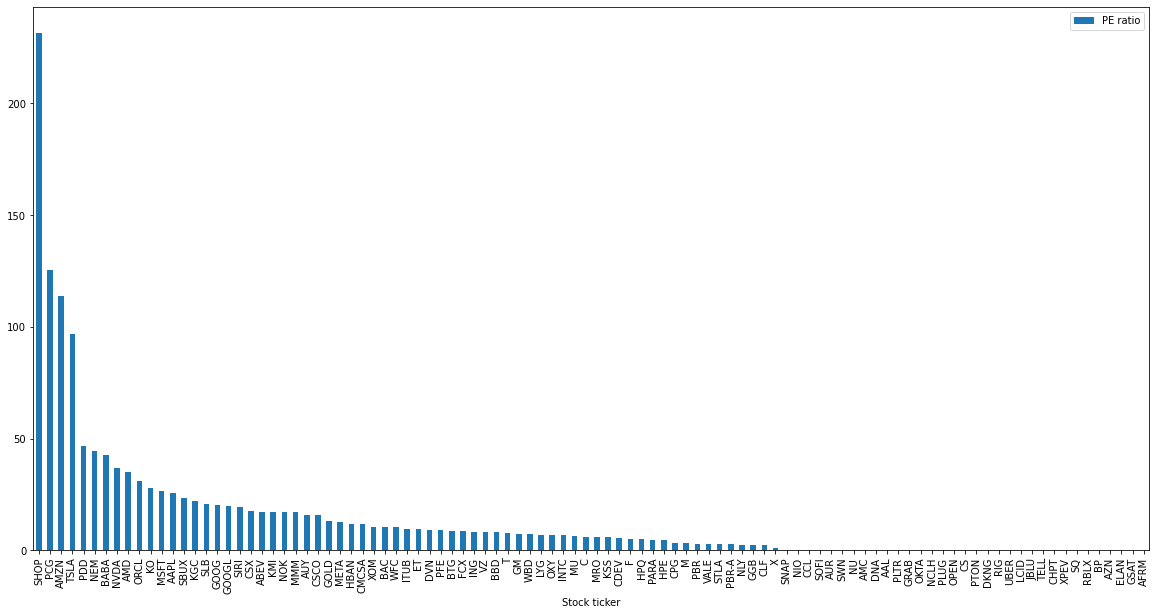

In [183]:
order_by_pe_ratio_df.plot(x ='Stock ticker', y='PE ratio', kind = 'bar',figsize=(20,10))
plt.show()

A plot that shows stocks from the 100 most active stocks from highest to lowest volume.

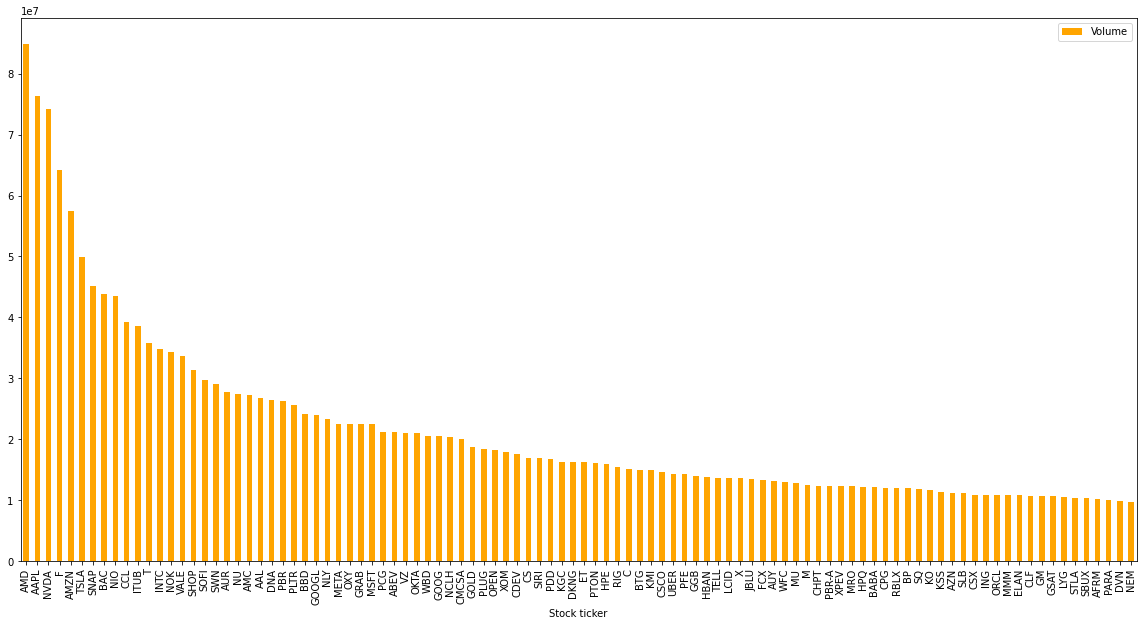

In [184]:
order_by_vol_df.plot(x ='Stock ticker', y='Volume', kind = 'bar',figsize=(20,10),color='orange')
plt.show()

A plot that shows stocks from the 100 most active stocks from cheapest to most expensive.

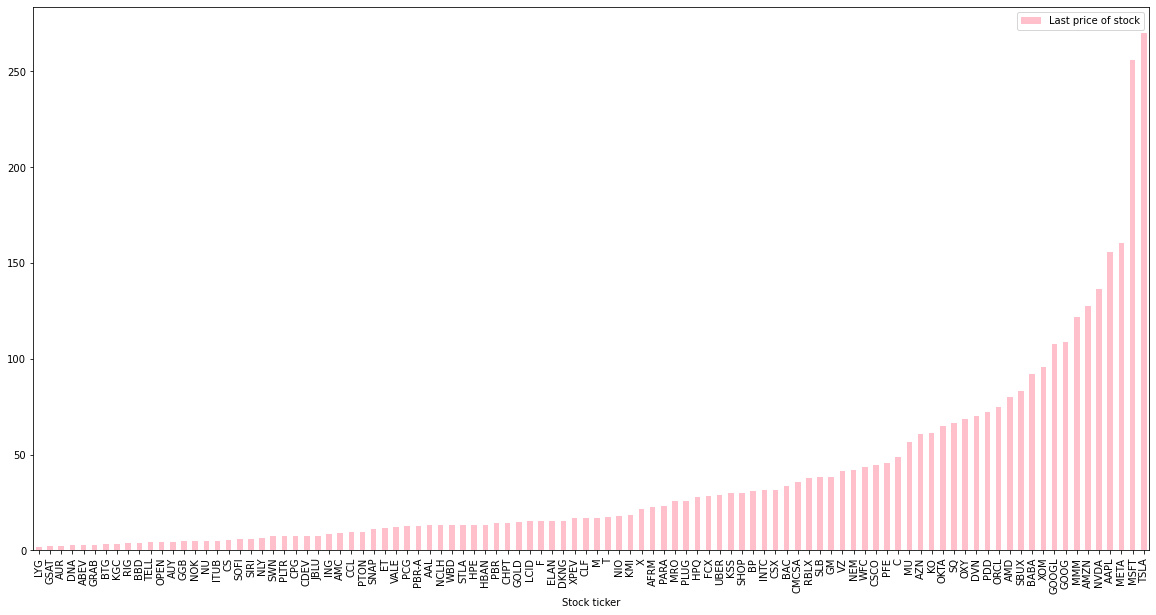

In [185]:
order_by_price_df.plot(x ='Stock ticker', y='Last price of stock', kind = 'bar',figsize=(20,10),color='pink')
plt.show()

### 8. Summary

In summary, we've downloaded two articles, parsed them for information, created functions to create dictionaries of the parsed information, saved those dictionaries as CSV files, converted those CSV files to pandas data frames, and finally, visualised a few of those data frames. 

This project is meant to be informative and general in nature, it is not applicable to anyone's personal situation. 

### 9. Future work ideas

In the future, I would love to gather more information on individual stocks such as historical data so that we can look at comparisons of stocks historically. I would also like to delve deeper into data displays and derive useful inferences that can be used for educational purposes. I think this project can be used as a springboard for my goal of shrinking the wealth gap. 

### 10. References

* “Cryptocurrency List & Prices, Top Cryptocurrencies.” Yahoo! Finance, Yahoo!, 20 Aug. 2022, https://finance.yahoo.com/cryptocurrencies/. 
* “Girls That Invest Podcast & Masterclass.” Girls That Invest, https://girlsthatinvest.com/. 
* “Most Active Stocks Today.” Yahoo! Finance, Yahoo!, 20 Aug. 2022, https://finance.yahoo.com/most-active?offset=0&amp;count=100. 

In [186]:
!pip install jovian --upgrade --quiet

In [187]:
import jovian

In [ ]:
jovian.commit(files=['most-active-stocks-next-page.csv', 'most-active-stocks.csv'])

<IPython.core.display.Javascript object>